In [18]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup

def get_subpages():
    base_link = "https://digital.bentley.umich.edu/midaily/search?date_filter=after&date_filter_options%5Bbegin%5D%5Bfld%5D=date_issued_yyyymmdd_ti&date_filter_options%5Bbegin%5D%5Bvalue%5D=20081231&date_issued_begin_dd=31&date_issued_begin_mm=12&date_issued_begin_yyyy=2008&f%5Bissue_sequence_field%5D%5B%5D=issue_sequence_1&page="

    # set up Selenium webdriver
    driver = webdriver.Chrome()
    driver.get(base_link)

    # wait for the element to load using WebDriverWait
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, "row-article-text")))

    # use Beautiful Soup to scrape the page
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # close the webdriver
    driver.quit()

    li_element = soup.find("ul", class_="pagination").find("li", class_="hidden-xs hidden-sm")
    a_element = li_element.find('a', href=True)
    max_pages = a_element.text

    subpages = [base_link + str(i) for i in range(1,int(max_pages) + 1)]
    return subpages
         
def get_article_links_and_dates(url, driver=None):
    import os
    from datetime import datetime
    import json

    if(driver is None):
        drive = webdriver.Chrome()
    driver.get(url)

    # wait for the element to load using WebDriverWait
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CLASS_NAME, "row-article-text")))

    # use Beautiful Soup to scrape the page
    soup = BeautifulSoup(driver.page_source, "html.parser")

    if os.path.exists('umich_article_pages.json'):
        # Open the JSON file for reading
        with open('umich_article_pages.json', 'r') as f:
            article_links = json.load(f)
    else:
        article_links = {}

    base_link = "https://digital.bentley.umich.edu"

    try:
        for div in soup.find_all("div", class_="row-article-text"):
            for a in div.find_all("a", href=True):
                if a["href"].startswith("/midaily"):
                    date_text = " ".join(a.find("h3").get_text().split()[:3])

                    # Parse the date string using datetime.strptime
                    date_obj = datetime.strptime(date_text, '%B %d, %Y')

                    # Format the date object as a string in the desired format
                    formatted_date = date_obj.strftime('%Y_%m_%d')
                    article_links[formatted_date] = [base_link + a["href"] + "/download_issue_text"]
    except Exception as e:
        print(f"Error encountered on link {url}: \n{e}")
    with open("umich_article_pages.json", "w") as outfile:
                json.dump(article_links, outfile, indent=4) 
    return(article_links)




In [22]:
subpages = get_subpages()
print(f"There are {len(subpages)} subpages")

There are 36 subpages


In [ ]:
driver = webdriver.Chrome()
for i, subpage in enumerate(subpages):
    print(f"Starting on subpage {i+1}.")
    get_article_links_and_dates(subpage, driver=driver)

In [1]:
import json 
with open('umich_article_pages.json', 'r') as f:
    article_links = json.load(f)

In [ ]:
from helpers.make_txt_entry import make_txt_entry
from helpers.zip_to_text import extract_zip_text
import os

school_name = "UMich"
for date, articles in article_links.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = extract_zip_text(articles[0])
            
        make_txt_entry(school_name="UMich", publication_date=date, text=article_text)
        print(f"Date {date} added.")

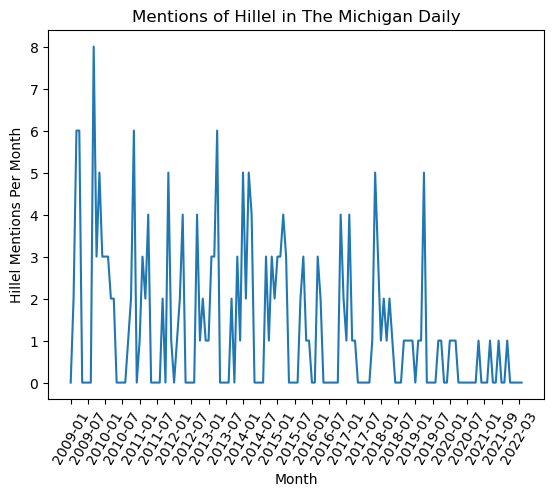

In [3]:
from helpers.graphers import monthly_grapher
from helpers.queries import hillel_counter

school_name = "UMich"
newspaper_name = "The Michigan Daily"
school_name_lower = school_name.lower()

UMich_pipeline = []

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=UMich_pipeline,
                query=hillel_counter,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in " + newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_hillel_mentions.png')


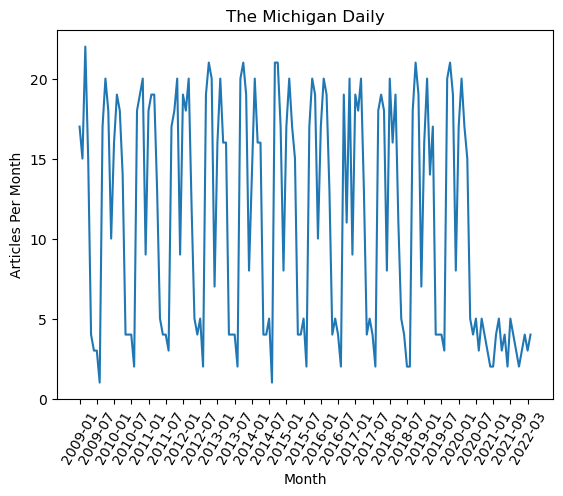

In [4]:
from helpers.queries import one_query
from helpers.graphers import monthly_grapher

school_name = "UMich"
newspaper_name = "The Michigan Daily"
school_name_lower = school_name.lower()

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=[],
                query=one_query,
                y_label="Articles Per Month",
                title=newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_monthly_articles.png')


grouped_data/csv/UMich_China.csv already exists.
grouped_data/pkl/monthly/UMich_China.pkl being read.


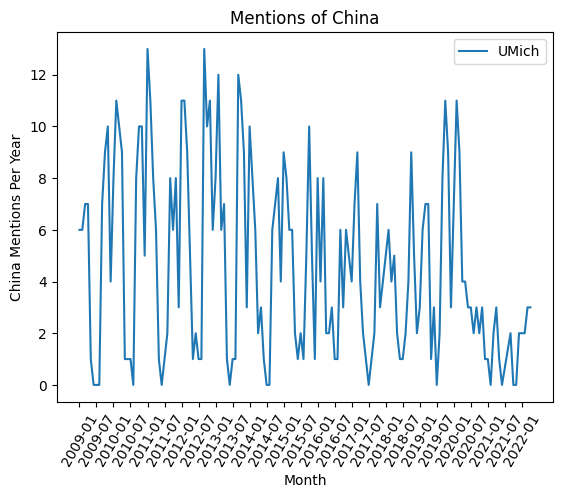

In [7]:
# Hyperparameters to Modify
school_name = 'UMich'
string = "China"
time_slice = 'monthly'

from helpers.graphers import grapher
from helpers.queries import count_query

school_names = [school_name]
save_pattern = '_'.join(school_names)+'_'+string.replace(' ','_')
grapher(school_names=school_names,
        pipeline=[],
        query=count_query(string),
        y_label=f"{string} Mentions Per Year",
        data_path="grouped_data",
        data_name=save_pattern,
        time_slice=time_slice,
        title=f"Mentions of {string}",
        img_path=f"figures/{school_name}/{save_pattern}_{time_slice}.png")